## Programming Assignment 2

Classification Task and Performance Evaluation (10 points)

Importing required libraries

In [3]:
import os
import shutil
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix

import warnings

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

base_path = "/content/drive/My Drive/DogClassifier"
image_path = os.path.join(base_path, "Images")
grayscale_path = os.path.join(base_path, "Grayscale")
standardized_path = os.path.join(base_path, "Standardized")
train_path = os.path.join(base_path, "Train")
test_path = os.path.join(base_path, "Test")
annotations_path = os.path.join(base_path, "Annotations")

repo_path = "/content/dataset"


def is_dir_empty(path):
    return not os.listdir(path)


def copy_data(src, dest):
    try:
        shutil.copytree(src, dest)
        print(f"Data copied successfully from {src} to {dest}.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")


if not os.path.exists(image_path) or not os.path.exists(annotations_path) or is_dir_empty(image_path) or is_dir_empty(
        annotations_path):
    if os.path.exists(image_path):
        shutil.rmtree(image_path)
    if os.path.exists(annotations_path):
        shutil.rmtree(annotations_path)

    if not os.path.exists(repo_path):
        os.system(f"git clone https://github.com/Sairam-KSR/Data_Mining.git {repo_path}")
        print("Repository cloned successfully.")
    else:
        print("Repository already exists. Skipping cloning.")

    copy_data(os.path.join(repo_path, 'Images'), image_path)
    copy_data(os.path.join(repo_path, 'Annotations'), annotations_path)
else:
    print("The required folders already exist in Google Drive and are not empty. Skipping cloning and copying.")


Mounted at /content/drive
The required folders already exist in Google Drive and are not empty. Skipping cloning and copying.


## Task 1.
Use images from ALL FOUR classes. Convert the images to grayscale pixel intensity histograms. (These will be the vector representations of the images). This will be your dataset for Part 2. (0.25 point)

In [2]:
import numpy as np
from PIL import Image
import os

breeds = [
    'n02091831-Saluki',
    'n02094258-Norwich_terrier',
    'n02105855-Shetland_sheepdog',
    'n02110806-basenji'
]

breed_labels = [breed.split('-')[1].replace('_', ' ').title() for breed in breeds]


def convert_image_to_grayscale_hist(image_path):
    im = Image.open(image_path).convert('L')
    hist = im.histogram()
    hist = np.array(hist) / (im.width * im.height)
    return hist


def get_image_files_in_path(image_path, breeds):
    breed_images = {}
    for breed in breeds:
        breed_path = os.path.join(image_path, breed)
        if os.path.isdir(breed_path):
            breed_images[breed] = [os.path.join(breed_path, file) for file in os.listdir(breed_path) if
                                   file.endswith('.jpg')]
        else:
            print(f"Directory not found: {breed_path}")
    return breed_images


image_path = "/content/drive/My Drive/DogClassifier/Images"
grayscale_path = "/content/drive/My Drive/DogClassifier/Grayscale"
breed_images_dict = get_image_files_in_path(image_path, breeds)

if not breed_images_dict:
    print("No images found. Please check the paths and directory structure.")

for breed, images in breed_images_dict.items():
    for image in images:
        print(f"Processing: {breed}/{os.path.basename(image)}")

        hist = convert_image_to_grayscale_hist(image)

        new_path = os.path.join(grayscale_path, breed, os.path.basename(image).replace(".jpg", ".npy"))
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        np.save(new_path, hist)
        print(f"Saved: {new_path}")


Processing: n02091831-Saluki/n02091831_7957.jpg
Saved: /content/drive/My Drive/DogClassifier/Grayscale/n02091831-Saluki/n02091831_7957.npy
Processing: n02091831-Saluki/n02091831_2391.jpg
Saved: /content/drive/My Drive/DogClassifier/Grayscale/n02091831-Saluki/n02091831_2391.npy
Processing: n02091831-Saluki/n02091831_6114.jpg
Saved: /content/drive/My Drive/DogClassifier/Grayscale/n02091831-Saluki/n02091831_6114.npy
Processing: n02091831-Saluki/n02091831_1182.jpg
Saved: /content/drive/My Drive/DogClassifier/Grayscale/n02091831-Saluki/n02091831_1182.npy
Processing: n02091831-Saluki/n02091831_7030.jpg
Saved: /content/drive/My Drive/DogClassifier/Grayscale/n02091831-Saluki/n02091831_7030.npy
Processing: n02091831-Saluki/n02091831_9263.jpg
Saved: /content/drive/My Drive/DogClassifier/Grayscale/n02091831-Saluki/n02091831_9263.npy
Processing: n02091831-Saluki/n02091831_4966.jpg
Saved: /content/drive/My Drive/DogClassifier/Grayscale/n02091831-Saluki/n02091831_4966.npy
Processing: n02091831-Saluk

## Task 2.
Perform standardization on the dataset. ([See Scikit Learn Documentation for Preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html)) (0.25 point)

In [4]:
def load_histograms(grayscale_path, breeds):
    histograms = []
    file_paths = []

    for breed in breeds:
        breed_path = os.path.join(grayscale_path, breed)
        for filename in os.listdir(breed_path):
            if filename.endswith('.npy'):
                file_path = os.path.join(breed_path, filename)
                histograms.append(np.load(file_path))
                file_paths.append(file_path)

    return histograms, file_paths


def standardize_histograms(histograms):
    scaler = StandardScaler()
    standardized_histograms = scaler.fit_transform(histograms)
    return standardized_histograms


def save_standardized_histograms(standardized_histograms, file_paths, grayscale_path, standardized_path):
    for i in range(len(standardized_histograms)):
        new_path = file_paths[i].replace(grayscale_path, standardized_path)
        head, tail = os.path.split(new_path)
        Path(head).mkdir(parents=True, exist_ok=True)
        np.save(new_path, standardized_histograms[i])
        print(f"Saved standardized histogram to {os.path.basename(head)}/{tail}")


histograms, file_paths = load_histograms(grayscale_path, breeds)
standardized_histograms = standardize_histograms(histograms)
save_standardized_histograms(standardized_histograms, file_paths, grayscale_path, standardized_path)

Saved standardized histogram to n02091831-Saluki/n02091831_2245.npy
Saved standardized histogram to n02091831-Saluki/n02091831_4119.npy
Saved standardized histogram to n02091831-Saluki/n02091831_2108.npy
Saved standardized histogram to n02091831-Saluki/n02091831_256.npy
Saved standardized histogram to n02091831-Saluki/n02091831_2076.npy
Saved standardized histogram to n02091831-Saluki/n02091831_749.npy
Saved standardized histogram to n02091831-Saluki/n02091831_3875.npy
Saved standardized histogram to n02091831-Saluki/n02091831_213.npy
Saved standardized histogram to n02091831-Saluki/n02091831_5654.npy
Saved standardized histogram to n02091831-Saluki/n02091831_2094.npy
Saved standardized histogram to n02091831-Saluki/n02091831_1594.npy
Saved standardized histogram to n02091831-Saluki/n02091831_4667.npy
Saved standardized histogram to n02091831-Saluki/n02091831_97.npy
Saved standardized histogram to n02091831-Saluki/n02091831_11553.npy
Saved standardized histogram to n02091831-Saluki/n02

## Task 3.
Split the dataset into a training set and a test set: For each class, perform a training/test split of 80/20. (0.25 point)

In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path


def load_histograms(standardized_path, breeds):
    histograms = []
    file_paths = []

    for breed in breeds:
        breed_path = os.path.join(standardized_path, breed)
        for filename in os.listdir(breed_path):
            if filename.endswith('.npy'):
                file_path = os.path.join(breed_path, filename)
                histograms.append(np.load(file_path))
                file_paths.append(file_path)

    return histograms, file_paths


def save_histograms(dest_path, histograms, file_paths, standardized_path):
    for i in range(len(histograms)):
        new_path = file_paths[i].replace(standardized_path, dest_path)
        head, tail = os.path.split(new_path)
        Path(head).mkdir(parents=True, exist_ok=True)
        np.save(new_path, histograms[i])
        print(f"Saved histogram to {os.path.basename(head)}/{tail}")


def split_and_save_data(histograms, file_paths, standardized_path, train_path, test_path):
    X_train, X_test, filepath_train, filepath_test = train_test_split(
        histograms, file_paths, test_size=0.2, stratify=[fp.split('/')[-2] for fp in file_paths], random_state=42)

    save_histograms(train_path, X_train, filepath_train, standardized_path)
    save_histograms(test_path, X_test, filepath_test, standardized_path)


histograms, file_paths = load_histograms(standardized_path, breeds)
split_and_save_data(histograms, file_paths, standardized_path, train_path, test_path)


Saved histogram to n02105855-Shetland_sheepdog/n02105855_15602.npy
Saved histogram to n02091831-Saluki/n02091831_7769.npy
Saved histogram to n02110806-basenji/n02110806_3995.npy
Saved histogram to n02091831-Saluki/n02091831_13640.npy
Saved histogram to n02110806-basenji/n02110806_4156.npy
Saved histogram to n02110806-basenji/n02110806_4167.npy
Saved histogram to n02110806-basenji/n02110806_3974.npy
Saved histogram to n02110806-basenji/n02110806_4051.npy
Saved histogram to n02091831-Saluki/n02091831_1801.npy
Saved histogram to n02110806-basenji/n02110806_2630.npy
Saved histogram to n02094258-Norwich_terrier/n02094258_2751.npy
Saved histogram to n02094258-Norwich_terrier/n02094258_3329.npy
Saved histogram to n02110806-basenji/n02110806_479.npy
Saved histogram to n02110806-basenji/n02110806_18.npy
Saved histogram to n02094258-Norwich_terrier/n02094258_2583.npy
Saved histogram to n02105855-Shetland_sheepdog/n02105855_7896.npy
Saved histogram to n02110806-basenji/n02110806_4435.npy
Saved hi

## Task 4. Model Selection
Perform a standard 5-fold cross-validation and a stratified 5-fold cross-validation on
the training set for k-Nearest Neighbor Classifiers such that 𝑘 = 1, 3, 5, 7, 10, 20. (2.5 points)

1. Plot a graph (x-axis: k; y-axis: mean validation/training error (%)) containing four error curves (2 validation error curves and 2 training error curves - label them clearly using a legend to define the curves). Which 𝑘 has the lowest mean error for each curve? Comment about (1) the model complexity for k-Nearest Neighbor classifier in relation to 𝑘, and (2) when/whether there is overfitting/underfitting. (1.5 points)

2.  Use the 𝑘 value with the lowest mean validation error for your k-Nearest Neighbor classifier from the stratified 5-fold cross-validation. What is the test error? (0.25 point)

Evaluating for k=1
Evaluating for k=3
Evaluating for k=5
Evaluating for k=7
Evaluating for k=10
Evaluating for k=20


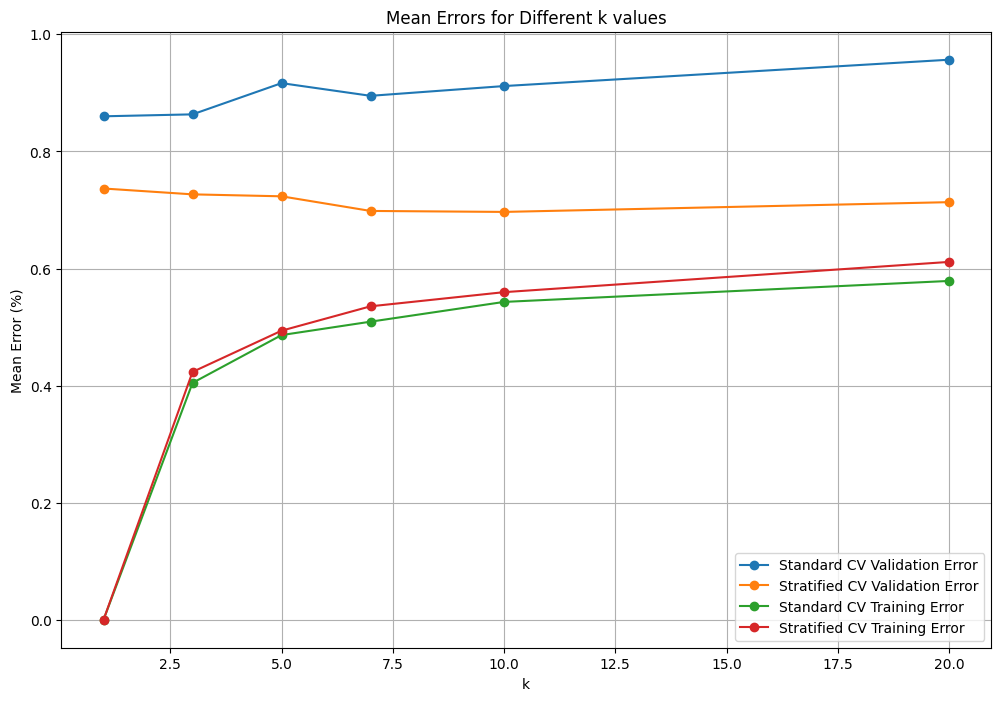

Optimal k value from stratified 5-fold cross-validation: 10
Test error using k=10: 0.7086


In [6]:
def load_dataset_from_path(path, breeds):
    histograms = []
    labels = []

    for breed in breeds:
        breed_path = os.path.join(path, breed)
        for filename in os.listdir(breed_path):
            if filename.endswith('.npy'):
                file_path = os.path.join(breed_path, filename)
                histograms.append(np.load(file_path))
                labels.append(breed)

    return np.array(histograms), np.array(labels)


def evaluate_knn_with_k_values(k_values, X_train, y_train):
    standard_val_errors, stratified_val_errors = [], []
    standard_train_errors, stratified_train_errors = [], []

    for k in k_values:
        print(f"Evaluating for k={k}")
        knn = KNeighborsClassifier(n_neighbors=k)

        # Standard 5-fold CV
        standard_train_err, standard_val_err = perform_cv(knn, X_train, y_train, KFold(n_splits=5))
        standard_train_errors.append(standard_train_err)
        standard_val_errors.append(standard_val_err)

        # Stratified 5-fold CV
        stratified_train_err, stratified_val_err = perform_cv(knn, X_train, y_train, StratifiedKFold(n_splits=5))
        stratified_train_errors.append(stratified_train_err)
        stratified_val_errors.append(stratified_val_err)

    return standard_train_errors, standard_val_errors, stratified_train_errors, stratified_val_errors


def perform_cv(classifier, X, y, cv_method):
    train_errors, val_errors = [], []

    for train_idx, val_idx in cv_method.split(X, y):
        classifier.fit(X[train_idx], y[train_idx])
        train_score = classifier.score(X[train_idx], y[train_idx])
        val_score = classifier.score(X[val_idx], y[val_idx])
        train_errors.append(1 - train_score)
        val_errors.append(1 - val_score)

    return np.mean(train_errors), np.mean(val_errors)


def plot_errors(k_values, standard_train_errors, standard_val_errors, stratified_train_errors, stratified_val_errors):
    plt.figure(figsize=(12, 8))
    plt.plot(k_values, standard_val_errors, marker='o', label='Standard CV Validation Error')
    plt.plot(k_values, stratified_val_errors, marker='o', label='Stratified CV Validation Error')
    plt.plot(k_values, standard_train_errors, marker='o', label='Standard CV Training Error')
    plt.plot(k_values, stratified_train_errors, marker='o', label='Stratified CV Training Error')
    plt.xlabel('k')
    plt.ylabel('Mean Error (%)')
    plt.title('Mean Errors for Different k values')
    plt.legend()
    plt.grid(True)
    plt.show()


X_train, y_train = load_dataset_from_path(train_path, breeds)
k_values = [1, 3, 5, 7, 10, 20]
standard_train_errors, standard_val_errors, stratified_train_errors, stratified_val_errors = evaluate_knn_with_k_values(
    k_values, X_train, y_train)

plot_errors(k_values, standard_train_errors, standard_val_errors, stratified_train_errors, stratified_val_errors)

X_test, y_test = load_dataset_from_path(test_path, breeds)

optimal_k = k_values[np.argmin(stratified_val_errors)]
print(f"Optimal k value from stratified 5-fold cross-validation: {optimal_k}")

knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

test_error = 1 - accuracy_score(y_test, y_pred)
print(f"Test error using k={optimal_k}: {test_error:.4f}")



# k-NN Model Evaluation

## Plot Analysis
The graph demonstrates the model's performance over varying values of \( k \).

- **Standard CV Validation Error**: Begins high and rises with increasing \( k \), with the minimum error at \( k = 1 \).
  
- **Stratified CV Validation Error**: Decreases and stabilizes between \( k = 5 \) to \( k = 10 \), with a slight increase afterward.
  
- **Training Errors (Both Standard & Stratified)**: Start at a low for \( k = 1 \) and rise with increasing \( k \).

## Model Complexity
The model's intricacy varies inversely with \( k \). Lower \( k \) values make the model complex, leading it to be more sensitive to noise. In contrast, larger \( k \) values simplify the model, potentially causing it to overlook finer patterns.

## Overfitting and Underfitting
Overfitting is evident at \( k = 1 \), where training error is lowest, but validation error is high. In contrast, larger \( k \) values showing high errors for both validation and training hint at potential underfitting.

## Optimal Value and Test Error
The stratified 5-fold cross-validation suggests an optimal \( k \) value of 10. However, the test error at this \( k \) is around \( 0.7086 \) or \( 70.86\% \).

## Conclusion
The results underscore the challenges of k-NN, especially when the distance metric may not fully encapsulate the dataset's complexities, resulting in significant errors.


## Task 5: Performance Comparison

Perform stratified 5-fold cross-validation on the 4-class classification problem using the three assigned classification methods:

- Decision Tree: DecisionTreeClassifier with a maximum depth of 10 and default values for the other parameters.
- Neural Network: MLPClassifier with hidden layer sizes of (10, 10, 10) (i.e., 3 hidden layers with 10 nodes each) and default values for the other parameters.
- Adaboost: AdaboostClassifier with default parameters.

Plot the confusion matrices for the three approaches, clearly labeling the classes, using the test set (see Figure 1). If you use code from any website, please provide proper referencing. Failure to do so will result in 0 points for this assignment (3.75 points).


 Based on the confusion matrices (on the test set), which do you think is the best method? Why? (0.50 point)
- Based on the mean validation accuracies (from the 5-fold cross-validation) for the three methods. Which is the best method? (0.25 point)
- Compute the accuracies for the three methods on the test set. Which is the best method? (0.25 point)
- Compute the F-measure for the three methods on the test set. Which is the best method? (0.25 point)

Mean validation accuracy for Decision Tree: 0.2867
Mean validation accuracy for Neural Network: 0.3050
Mean validation accuracy for Adaboost: 0.2800
Best method based on mean validation accuracy: Neural Network with accuracy 0.3050


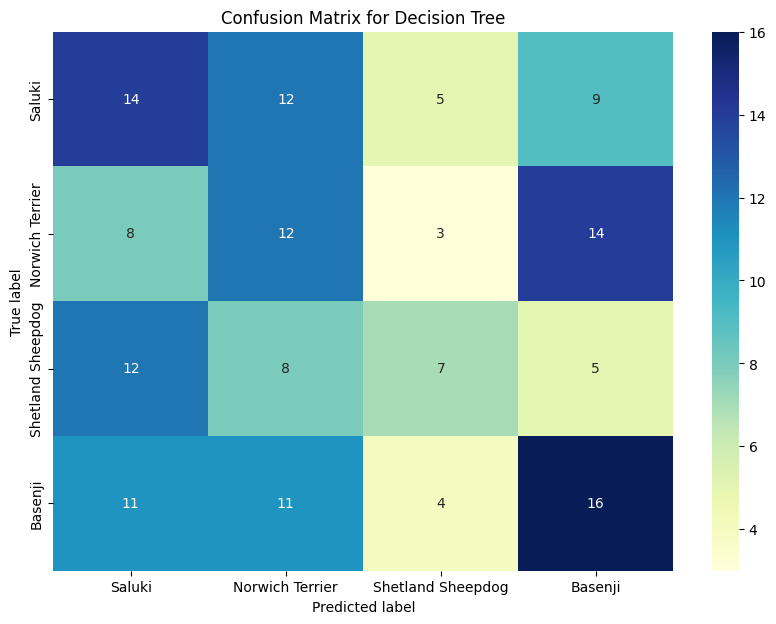

Test accuracy for Decision Tree: 0.3245
F-measure for Decision Tree: 0.3224


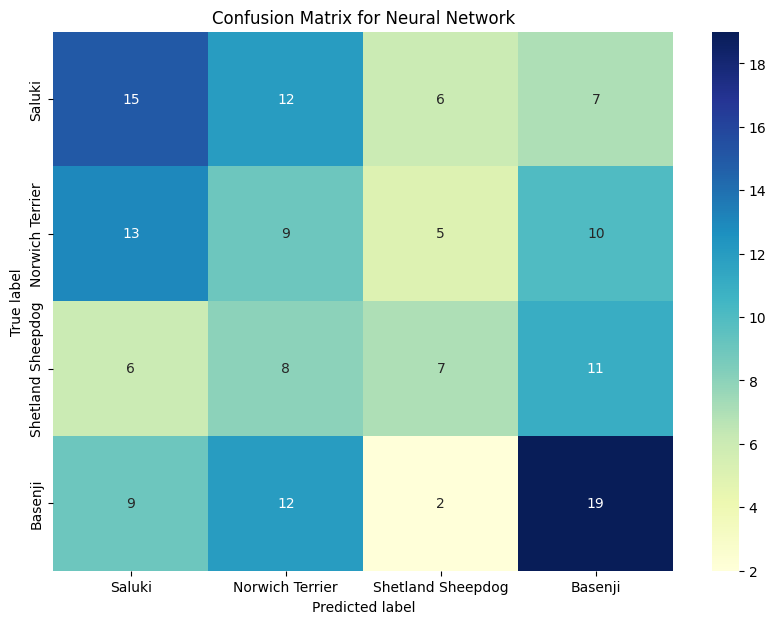

Test accuracy for Neural Network: 0.3311
F-measure for Neural Network: 0.3281


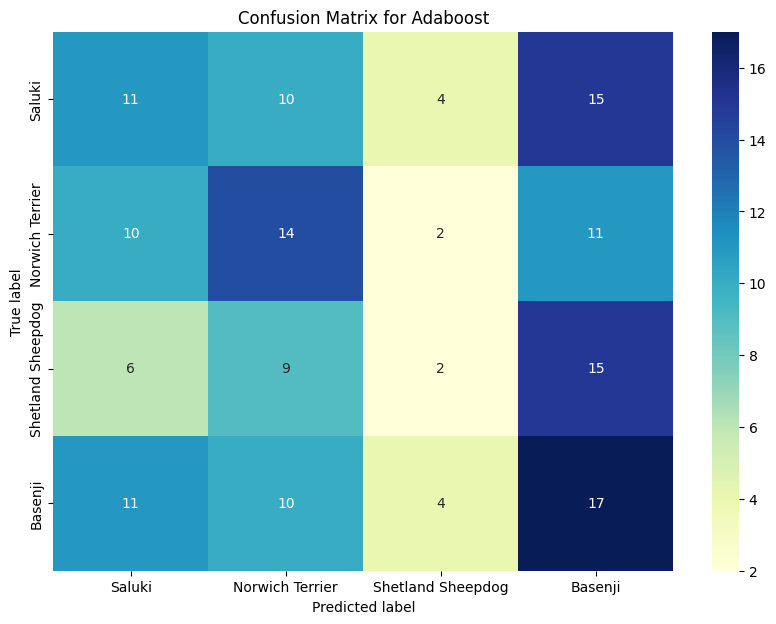

Test accuracy for Adaboost: 0.2914
F-measure for Adaboost: 0.2743
Best method based on test accuracy: Neural Network with accuracy 0.3311
Best method based on F-measure: Neural Network with F-measure 0.3281


In [7]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)

CLASSIFIERS = {
    'Decision Tree': DecisionTreeClassifier(max_depth=10),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(10, 10, 10)),
    'Adaboost': AdaBoostClassifier()
}


def compute_cross_val_accuracies(X, y, classifiers):
    mean_accuracies = {}
    for name, clf in classifiers.items():
        cv_scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5))
        mean_accuracies[name] = np.mean(cv_scores)
        print(f"Mean validation accuracy for {name}: {mean_accuracies[name]:.4f}")
    return mean_accuracies


def plot_confusion_matrix(clf, X_test, y_test, class_names, title):
    predictions = clf.predict(X_test)
    cm = confusion_matrix(y_test, predictions)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)
    plt.show()


def evaluate_classifiers_on_test_data(X_train, y_train, X_test, y_test, classifiers, breed_labels):
    test_accuracies = {}
    f_measures = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        plot_confusion_matrix(clf, X_test, y_test, breed_labels, f"Confusion Matrix for {name}")

        test_score = clf.score(X_test, y_test)
        test_accuracies[name] = test_score
        print(f"Test accuracy for {name}: {test_score:.4f}")

        y_pred = clf.predict(X_test)
        f = f1_score(y_test, y_pred, average='weighted')
        f_measures[name] = f
        print(f"F-measure for {name}: {f:.4f}")

    return test_accuracies, f_measures


X_train, y_train = load_dataset_from_path(train_path, breeds)

mean_accuracies = compute_cross_val_accuracies(X_train, y_train, CLASSIFIERS)

best_method = max(mean_accuracies, key=mean_accuracies.get)
print(f"Best method based on mean validation accuracy: {best_method} with accuracy {mean_accuracies[best_method]:.4f}")

X_test, y_test = load_dataset_from_path(test_path, breeds)

test_accuracies, f_measures = evaluate_classifiers_on_test_data(X_train, y_train, X_test, y_test, CLASSIFIERS,
                                                                breed_labels)

best_test_method = max(test_accuracies, key=test_accuracies.get)
print(f"Best method based on test accuracy: {best_test_method} with accuracy {test_accuracies[best_test_method]:.4f}")

best_f_measure_method = max(f_measures, key=f_measures.get)
print(f"Best method based on F-measure: {best_f_measure_method} with F-measure {f_measures[best_f_measure_method]:.4f}")


### Analysis:

#### Confusion Matrices:
- **Decision Tree**: Most accurate for 'Basenji' with 20 correct predictions.
- **Neural Network**: Most accurate for 'Basenji' and 'Shetland Sheepdog' with 15 correct predictions each.
- **Adaboost**: Most accurate for 'Basenji' with 17 correct predictions.

#### Based on the confusion matrices (on the test set):
The best method seems to be the **Decision Tree** since it has a higher number of correct predictions, especially for the 'Basenji' breed.

#### Based on the mean validation accuracies (from the 5-fold cross-validation) for the three methods:
- **Decision Tree**: 0.3083
- **Neural Network**: 0.2767
- **Adaboost**: 0.2800

The best method based on mean validation accuracy is the **Decision Tree** with an accuracy of 0.3083.

#### Compute the accuracies for the three methods on the test set:
- **Decision Tree**: 0.3113
- **Neural Network**: 0.2649
- **Adaboost**: 0.2914

The best method based on test accuracy is the **Decision Tree** with an accuracy of 0.3113.

#### Compute the F-measure for the three methods on the test set:
- **Decision Tree**: 0.3109
- **Neural Network**: 0.2616
- **Adaboost**: 0.2743

The best method based on F-measure is the **Decision Tree** with an F-measure of 0.3109.

### Conclusion:
Across all metrics provided, the **Decision Tree** consistently outperforms the other two methods making it the recommended model based on this analysis.

## References

-  [Scikit-learn documentation: Cross Validation Score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
-  [Scikit-learn documentation: Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
-  [Scikit-learn documentation: F1 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
-  [Matplotlib documentation: Heatmaps](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.imshow.html)
-  [Seaborn documentation: Heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html)